<a href="https://colab.research.google.com/github/Leo-Vincenzi/PUC-MVP_2/blob/main/MVP2_Machine_Learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/MVP2_PUC_Logo.jpg" width="950"/>

# MVP Sprint 2: Machine Learning & Analytics
---
## Professora: Tatiana Escovedo
## Aluno: Leonardo Braga De Vincenzi
### Título: Modelos de *Machine Learning* para detecção de fraudes de cartão de crédito
##### (Abril/2024)
---

Nessa seção inicial configuraremos o MVP para não exibir mensagens de aviso.

In [1]:
# Configurando para não exibir os warnings no meio da execução do MVP
import warnings
warnings.filterwarnings("ignore")

## 1.0 Definição do Problema
---
**Relevância**

A fraude em cartões de crédito é um problema global que causa enorme prejuízo. De acordo com o relatório *Card Fraud Losses Worldwide*, publicação comercial que cobre a indústria global de cartões de pagamento, perdas causadas por fraudes em cartões de crédito em todo o mundo chegarão a marca de **49** bilhões de dólares até **2030**. No Brasil, duas em cada dez pessoas já tiveram seus cartões de crédito fraudados.

Nesse viés, o advento do *Big Data* e a evolução de modelos mais robustos de *Machine Learning* permitiu o desenvolvimento de ferramentas que passaram a detectar e prevenir essas fraudes de maneira mais ágil e eficaz.

**Qual o objetivo desse MVP?**

O objetivo desse MVP é testar academicamente modelos de *Machine Learning* para alcançar a detecção de fraudes de cartão de crédito. Lembrando que o foco não é descobrir o melhor resultado, mas mostrar por meio do MVP o domínio e o conhecimento do assunto abordado.

**Como fazer isso?**

Inicialmente trataremos os dados, verificando por meio de estatísticas descritivas, a existência de dados ausentes e dados desequilibrados.

Depois exploraremos estatisticamente os dados, verificando as transações por tempo, seus valores e suas correlações.

Em seguida usaremos os modelos preditivos usando os métodos *ensemble* mais populares (algoritmos que utilizam vários modelos matemáticos que buscam obter um modelo final com melhores resultados), tais como *voting, bagging e boosting*, para um problema de classificação binária (transação fraude/não fraude).

Ao final, compararemos seus resultados.

**Sobre o *dataset* utilizado**

O *dataset* utilizado neste projeto contêm transações de cartões de crédito, efetuadas por clientes europeus, obtidas no mês setembro de 2013. Este conjunto de dados apresenta transações ocorridas durante dois dias, onde foram verificadas **492** fraudes em um total de em **284.807** transações financeiras. Trata-se de um conjunto de dados altamente desequilibrado, já que a classe positiva (de fraudes) representa apenas **0,17%** do total das transações abordadas.

Ele contém apenas dados de entrada numéricos, que são o resultado de uma transformação PCA (*Principal Component Analysis*). Esta foi empregada por ser considerada uma transformação linear ótima, sendo dessa forma muito utilizada para o reconhecimento de padrões.

**Dicionário de atributos**

* **Time** - Tempo transcorrido desde o início da coleta de dados;
* **Amount** - Valores das transações;
* **Class** - Valor-alvo que define se uma transação foi fraudulenta ou não: Normal = 0 e Fraude = 1;
* **(V1, V2, V3, ... V28)** - Valores que caracterizam as transações, e obtidos a partir da transformação PCA, técnica essa de redução de dimensionalidade que visa preservar a confidencialidade de dados dos clientes.

**Restrições do dataset**

Projetos que testam modelos preditivos de *Machine Learning* costumam necessitar de *dataset* suficientemente robusto para que os seus resultados sejam coerentes e válidos, permitindo que sejam grande o suficiente para ocorra um treino correto para a validação dos seus modelos.

E a limitação do *GitHub* em receber *upload* de arquivos maiores que 25 MB restringe a obtenção desses resultados, aumentando a dificuldade de obter apurações palpáveis para esse tipo de projeto.

Devido a questões de confidencialidade, não foram fornecidas as todas características originais e/ou outras informações sensíveis sobre os dados dos clientes de cartão de crédito.

**Observações importantes**

* As características **V1, V2, V3, ... V28** são componentes numéricos obtidos com PCA;
* Os únicos atributos que não foram transformados com PCA são "**Time**" e "**Amount**" e "**Class**";
* O atributo "**Time**" contém os segundos decorridos entre cada transação e a primeira transação;
* O atributo "**Amount**" é o valor da transação, e pode ser usado para aprendizado sensível em relação ao custo, dependendo da observação;
* O atributo "**Class**" é a resposta alvo da questão, e assume valor 1 (positivo) em caso de fraude e 0 (negativo) no caso contrário, ou seja, em uma transação normal.

## 2.0 Carga de Dados
---

Nessa seção iremos importar bibliotecas e parametrizar algumas variáveis de uso geral. E iremos usar a biblioteca *Pandas* (*Python Data Analysis Library*) para carregar de o arquivo .csv disponível online. O desafio aqui foi carregar um arquivo de tamanho **143,8** MB no *GitHub*, que possui limitação de *download* de **25** MB.

In [2]:
# Fazendo os imports das bibliotecas
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
!pip install catboost -q
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  # métrica usada para RandomForrestClassifier
NUM_ESTIMATORS = 100 # número de estimadores usados ​​para RandomForrestClassifier
NO_JOBS = 4 # número de jobs paralelos usados ​​para RandomForrestClassifier

# Define o percentual de divisão do dataframe em TRAIN/VALIDATION/TEST
VALID_SIZE = 0.20 # validação simples usando train_test_split
TEST_SIZE = 0.20 # tamanho do teste usando_train_test_split

NUMBER_KFOLDS = 5 # número de KFolds para validação cruzada
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 # número de iterações
EARLY_STOP = 50 # paradas antecipadas
OPT_ROUNDS = 1000  # será ajustado posteriormente com base nas melhores rodadas
VERBOSE_EVAL = 50 # mostra resultado da métrica

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.4 MB/s eta 0:00:00


Guardaremos em **Dataset** o dataframe das movimentações de cartões de crédito. Por causa do grande tamanho do seu arquivo original ".csv" obtido no site *Kaggle* (> que 25 Mbytes), não foi possível baixá-lo diretamente para o GitHub.

In [3]:
# Carregando dataset - arquivo .CVS acessando URL no GitHub
df1 = pd.read_csv("https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/Creditcard1.csv", sep = ',')
df2 = pd.read_csv("https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/Creditcard2.csv", sep = ',')
df3 = pd.read_csv("https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/Creditcard3.csv", sep = ',')
df4 = pd.read_csv("https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/Creditcard4.csv", sep = ',')
df5 = pd.read_csv("https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/Creditcard5.csv", sep = ',')
df6 = pd.read_csv("https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/Creditcard6.csv", sep = ',')

# Monta o dataset original de 150 MB que sofreram "split", concatenando a seguir 6 arquivos de 25 MB
dataset = pd.concat([df1,df2,df3,df4,df5,df6])

Verificaremos também a versão da **Matplotlib** instalada.

In [4]:
print(f"A versão MatPlotLib instalada é a {mpl.__version__}")

A versão MatPlotLib instalada é a 3.7.1


## 3.0 Observação dos Dados
---
Preliminarmente verificaremos informações básicas iniciais que podemos obter do nosso *dataset*.

In [5]:
print("Tamanho do Dataset: A tabela de dados Credit-Card-Fraud-Detection contém",dataset.shape[0],"linhas e", dataset.shape[1], "colunas")

Tamanho do Dataset: A tabela de dados Credit-Card-Fraud-Detection contém 284807 linhas e 31 colunas


Verificamos que nosso objeto de estudo é um robusto *dataset*, sucificente para o objetivo desse MVP.

Mostraremos a identificação dos nomes dos atributos de coluna no *dataset*.

In [6]:
dataset.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

A primeira linha do *dataset* contém o nome dos atributos.

Observaremos a seguir como estão organizados os dados e como eles se relacionam, categorizaremos algumas colunas, faremos algumas perguntas para melhor entendê-lo e tiraremos algumas conclusões acerca de seu conjunto.

Começamos examinando as primeiras e as últimas 5 linhas do *dataset*.

In [7]:
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47307,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
47308,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
47309,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
47310,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Observamos por essa amostra do *dabaset* que o atributo "**Time**" apresenta transações ocorrendo tanto em momentos distintos como simultâneos.

Também verificamos que o atributo "**Class**" foi caracterizado pelos valores 0 e 1.

Por fim verificamos que o atributo "**Amount**" possui diversos e diferentes valores realizados pelas transações financeiras feitas pelo cartão de crédito.

Vejamos mais detalhes dos dados que estamos trabalhando.

In [8]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Olhando para o atributo **Time**, verificamos que o dataset contêm **284.807** transações obtidas durante **2** dias consecutivos.

A primeira transação se inicia em 0 segundos e a última em 172.792 segundos (lembrando que 2 dias possuem 172.800 segundos). As transações distribuem-se por entre esses 2 dias, algumas ocorrendo simultaneamente, outras espaçadas por alguns segundos.


Verificaremos abaixo o número de valores únicos de cada atributo.

In [9]:
dataset.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

A única informação relevante obtida pela análise dos valores únicos do nosso *dataset* é que, de um total de **284.807** transações de cartão de crédito, **124.592** ocorreram em momentos cronológicos únicos.

Verificaremos agora qual o valor mais frequente (moda) para cada atributo do conjunto de dados do dataset.

In [10]:
moda = dataset.mode()
moda[:1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,163152.0,1.245674,-0.326668,-2.752041,-0.842316,-0.562777,-1.011073,-0.432126,-0.160211,0.170362,-0.075186,-0.356749,-0.07346,-0.51776,0.406969,1.124147,-0.371962,-0.601957,-0.438992,-0.33059,-0.18037,-0.262581,-0.816264,0.020675,0.357827,0.186423,-0.398828,-0.035866,-0.060282,1.0,0.0


Como as transações marcadas em segundos pelo atributo "**Time**" ocorreram de forma distribuida durante 2 dias, o atributo "**Class**" possui apenas 2 valores (0 e 1), o atributo "**Amount**" representa o valor gasto na transação e os atributos "**V1 a V28**" passaram por uma transformação linear, a obtenção do valor mais frequente (moda) do conjunto de dados dos atributos não acrescenta muito em nossa análise.

### 3.1. Verificação dos Dados Ausentes

Vamos verificar se há algum dado faltando no nosso *dataset*.

In [11]:
total = dataset.isnull().sum().sort_values(ascending = False)
percent = (dataset.isnull().sum()/dataset.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percentual']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Concluímos que não há dados faltantes em todo o conjunto do nosso *dataset*.

### 3.2. Verificação do Desequilíbrio dos Dados

Vamos verificar o desequilíbrio dos dados em relação ao atributo **"Class"**.


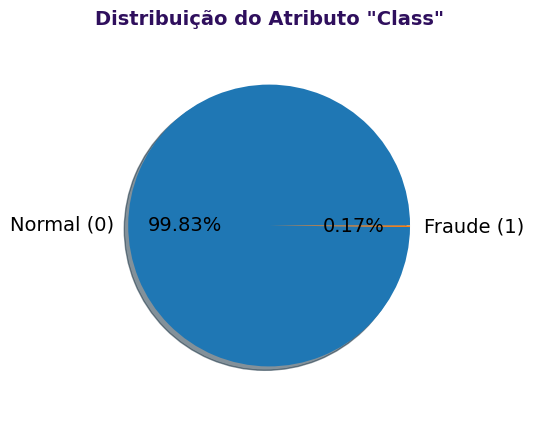

In [12]:
# Plotando um gráfico pizza mostrando a distribuição do atributo "Class"
counts = dataset['Class'].value_counts()
labels = ["Normal (0)", "Fraude (1)"] #labels = counts.index
explode = (0, 0)

# Definindo as linhas gerais do gráfico
plt.figure(figsize = (4, 5))
plt.pie(x=counts, labels=labels, explode=explode, autopct = '%1.2f%%', startangle=0, shadow=True, textprops={'fontsize': 14})
plt.title('Distribuição do Atributo "Class"', weight = 'bold', color = '#2F0F5D', fontsize = 14)
plt.axis('equal')
plt.show()

Apenas **0,17%** (**492** ocorrências) das transações foram fraudulentas. Isso significa que temos dados altamente desequilibrados em relação ao atributo **"Class"**.

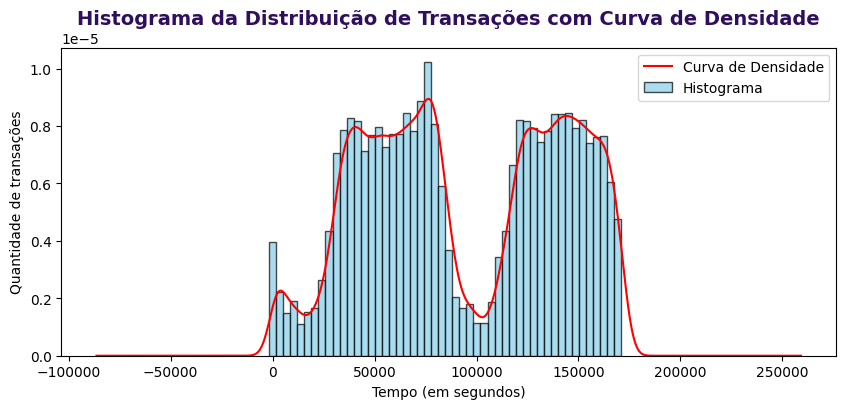

In [13]:
# Plotando um histograma de distribuição de transações com curva de densidade sobreposta
fig, ax = plt.subplots(figsize = (10, 4))
ax.hist(dataset['Time'], bins = 50, edgecolor = 'black', alpha = 0.7, color = 'skyblue', align = 'left', density = True)
dataset['Time'].plot(kind = 'kde', color = 'red', ax = ax)

# Definindo as linhas gerais do gráfico
ax.set_xlabel('Tempo (em segundos)')
ax.set_ylabel('Quantidade de transações')
ax.set_title('Histograma da Distribuição de Transações com Curva de Densidade', weight = "bold", color = "#2F0F5D", fontsize = 14)
ax.legend(['Curva de Densidade', 'Histograma'])
plt.show()

Percebemos que há uma clara diferença na quantidade de transações com cartões de crédito com relação ao tempo. Verificamos que elas ocorrem de forma cíclica durante as 48h de registro do nosso *dataset*, dependendo do horário, havendo maior número durante o dia, e diminuindo o número de transações à noite, o que faz todo sentido.

## 4.0 Análise Exploratória de Dados
---

Independentemente do domínio ou da aplicação, a análise exploratória de dados, com base na estatística, é uma ferramenta essencial para a compreensão do mundo por meio dos dados.

Ela permite analisar dados de maneira significativa, fornecendo uma estrutura lógica e objetiva que permite explorar padrões, tomar decisões e validar conclusões por meio de métodos científicos.

### 4.1. Transações por Tempo

In [14]:
class_0 = dataset.loc[dataset['Class'] == 0]["Time"]
class_1 = dataset.loc[dataset['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
plot(fig)

'temp-plot.html'

As transações fraudulentas têm uma distribuição mais uniforme do que as transações válidas, já que são distribuídas igualmente no tempo, o que demonstra que os fraudadores agem até mesmo durante a noite, mostrando não haver um comportamento cronológico para a ação de fraudadores.

Vejamos mais detalhes da distribuição de tempo de ambas as classes de transação (normal e fraudulenta), bem como dos valores agregados de contagem e quantidade de transações, por hora.

In [15]:
# Converteremos a unidade de tempo para horas, dividindo a atributo "Time" por 3600, e adicionando o atributo "Hour" em nosso dataset
dataset['Hour'] = dataset['Time'].apply(lambda x: np.floor(x / 3600))

tmp = dataset.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


A seguir veremos os resultados da tabela acima de forma gráfica.

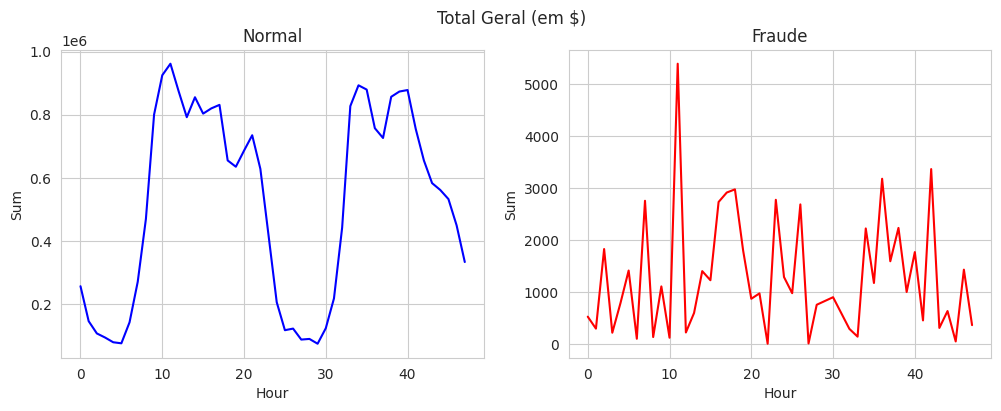

In [39]:
# Plotando 2 gráficos lado a lado (Fraude e Normal) - Total Geral
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0], color="blue").set(title="Normal")
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red").set(title="Fraude")
plt.suptitle("Total Geral (em $)")
plt.show();

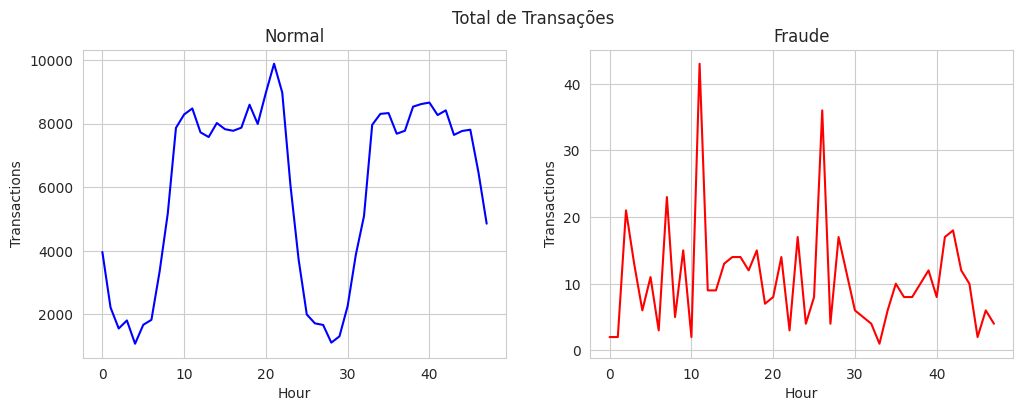

In [40]:
# Plotando 2 gráficos lado a lado (Fraude e Normal) - Total de Transações
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0], color="blue").set(title="Normal")
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red").set(title="Fraude")
plt.suptitle("Total de Transações")
plt.show();

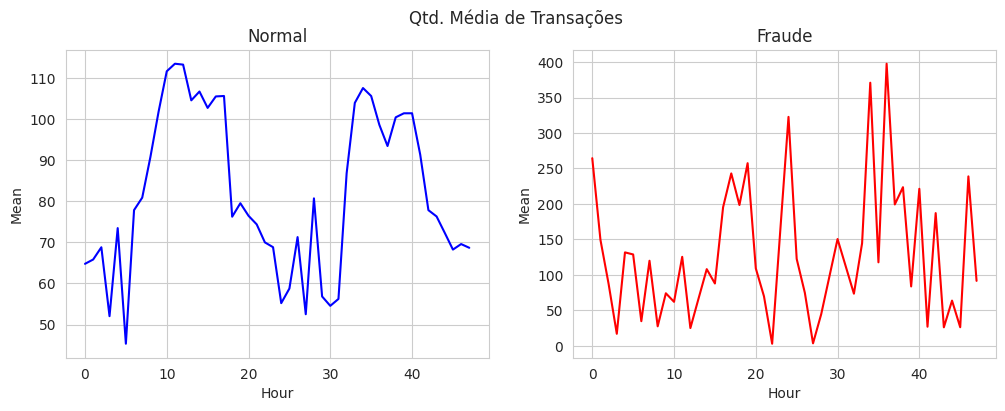

In [41]:
# Plotando 2 gráficos lado a lado (Fraude e Normal) - Qtd. Média de Transações
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0], color="blue").set(title="Normal")
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red").set(title="Fraude")
plt.suptitle("Qtd. Média de Transações")
plt.show();

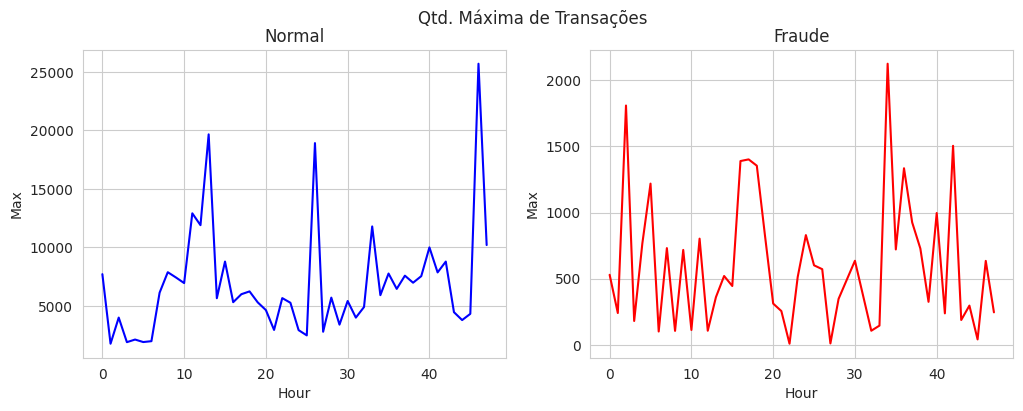

In [42]:
# Plotando 2 gráficos lado a lado (Fraude e Normal) - Qtd. Máxima de Transações
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0], color="blue").set(title="Normal")
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red").set(title="Fraude")
plt.suptitle("Qtd. Máxima de Transações")
plt.show();

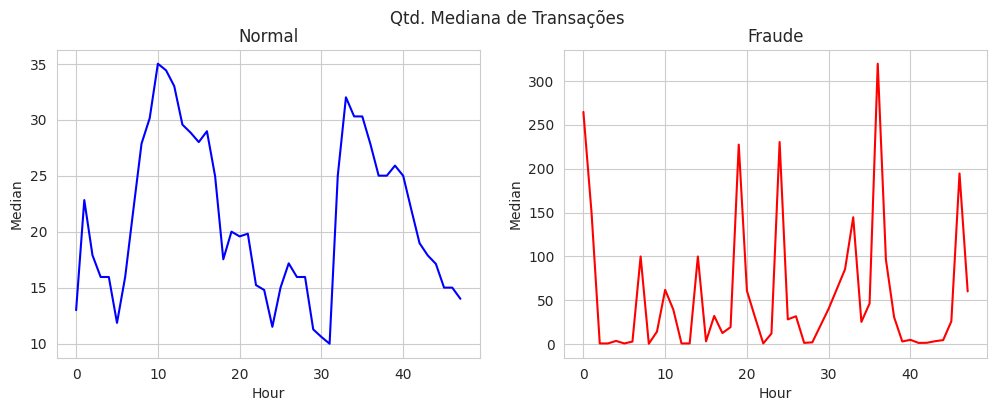

In [43]:
# Plotando 2 gráficos lado a lado (Fraude e Normal) - Qtd. Mediana de Transações
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0], color="blue").set(title="Normal")
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red").set(title="Fraude")
plt.suptitle("Qtd. Mediana de Transações")
plt.show();

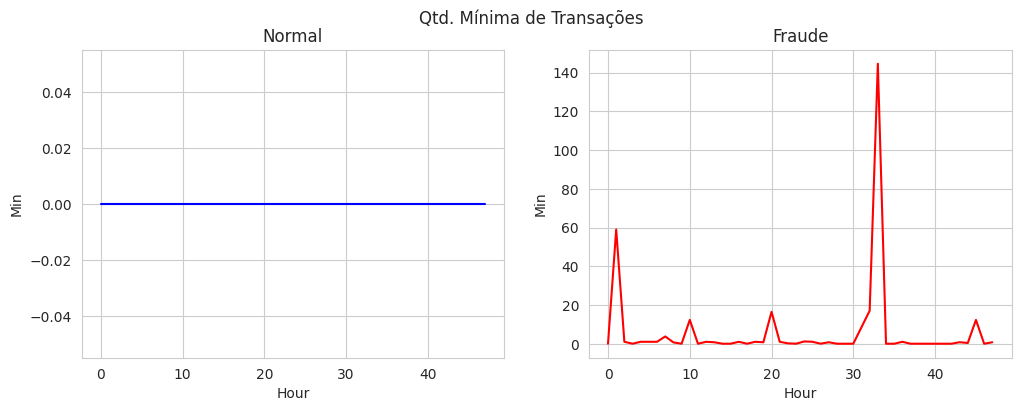

In [44]:
# Plotando 2 gráficos lado a lado (Fraude e Normal) - Qtd. Mínima de Transações
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0], color="blue").set(title="Normal")
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red").set(title="Fraude")
plt.suptitle("Qtd. Mínima de Transações")
plt.show();

### 4.2. Valor das Transações

Analisaremos o valor das transações por meio de *boxplot* (ou caixa de bigodes), gráfico que mostra a forma, a tendência central e a variabilidade dos dados. Esse gráfico foi escolhido porque é capaz de exibir a distribuição de dados com base em um resumo de cinco valores: mínimo, primeiro quartil, mediana, terceiro quartil e máximo.

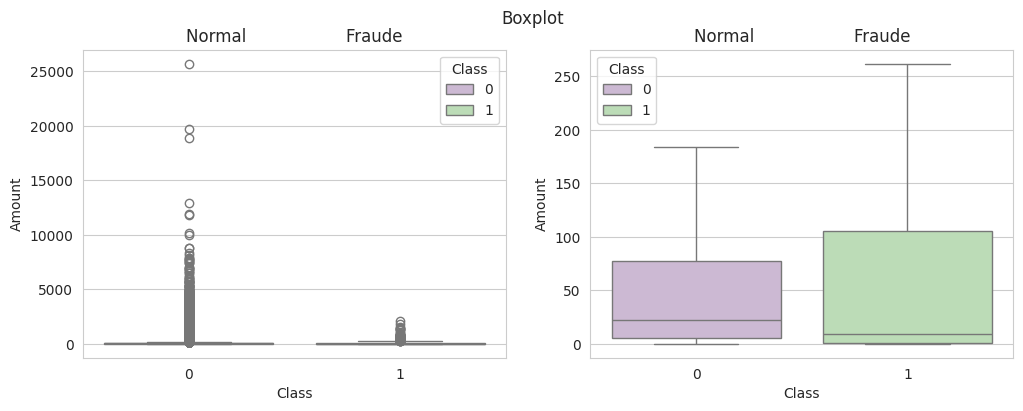

In [49]:
# Plotando 2 gráficos boxplot lado a lado (Fraude e Normal)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=dataset, palette="PRGn",showfliers=True).set(title="Normal                   Fraude")
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=dataset, palette="PRGn",showfliers=False).set(title="Normal                   Fraude")
plt.suptitle("Boxplot")
plt.show();

Comparando as linhas medianas de cada *boxplot*, como elas estão ambas dentro das suas caixas, vemos que não há grandes diferenças entre as duas classes (normal e fraude). Percebemos que os *outliers* são mais comuns em transações normais.Também verificamos que as transações fraudulentas são feitas - em sua maioria - com valores menores que as transações normais, talvez motivadas para não despertarem suspeitas.

Claramente as transações fraudulentas são mais homogêneas.

Veremos a seguir a descrição estatística da classe 0 (transação normal, ou seja, sem fraude).

In [45]:
tmp_df = dataset[['Amount','Class']].copy()
class_0 = tmp_df.loc[tmp_df['Class'] == 0]['Amount']
class_0.describe() # descrição estatística da classe 0 (normal, não fraude)

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Agora exibimos a descrição estatística da classe 1 (transação fraudulenta).

In [46]:
class_1 = tmp_df.loc[tmp_df['Class'] == 1]['Amount']
class_1.describe() # descrição estatística da classe 1 (fraude)

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Podemos concluir que a transação normal tem valor médio maior, Q1 maior, Q3 e Q4 menores e outliers maiores; transações fraudulentas têm um Q1 e média menores, um Q4 maior e valores discrepantes menores.

Vamos representar graficamente as transações fraudulentas (**Amount**) em relação ao tempo. O tempo mostrado é em segundos, a partir do início do período (total de 48h, ou seja, durante 2 dias).

In [25]:
fraud = dataset.loc[dataset['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Quantidade de transações fraudulentas',
          xaxis = dict(title = 'Time [s]', showticklabels=True),
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
plot(fig)

'temp-plot.html'

### 4.3. Correlação de Recursos

O coeficiente de correlação de Pearson pode ter um intervalo de valores de +1 a -1. Um valor de 0 indica que não há associação entre as duas variáveis. Um valor maior que 0 indica uma associação positiva. Isto é, à medida que o valor de uma variável aumenta, o mesmo acontece com o valor da outra variável.

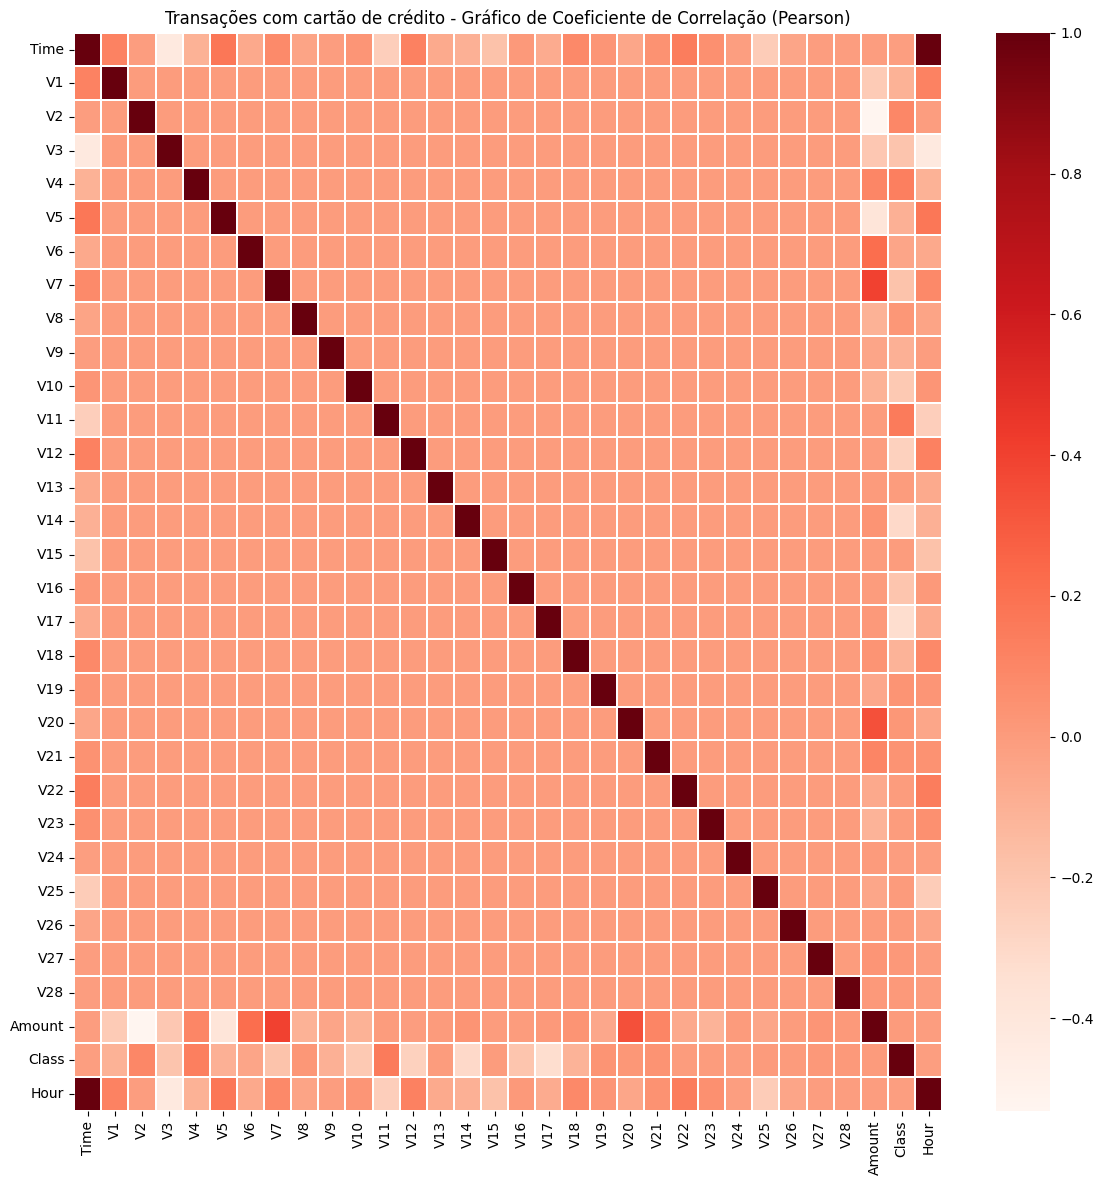

In [26]:
# plotando o gráfico de Pearson
plt.figure(figsize = (14,14))
plt.title('Transações com cartão de crédito - Gráfico de Coeficiente de Correlação (Pearson)')
corr = dataset.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

Como esperado, não há correlação notável entre os recursos **V1** a **V28** (linha escura diagonal central).

Verificamos que há certas correlações entre alguns desses recursos e o atributo **Time** (correlação inversa com **V3**) e o atributo **Amount** (correlação direta com **V7** e **V20**, correlação inversa com os atributos **V1** e **V5**).

Vamos traçar os atributos correlacionados e inversamente correlacionados no mesmo gráfico. Iremos começar com os atributos diretamente correlacionados: {V20; Amount} e {V7; Amount}.

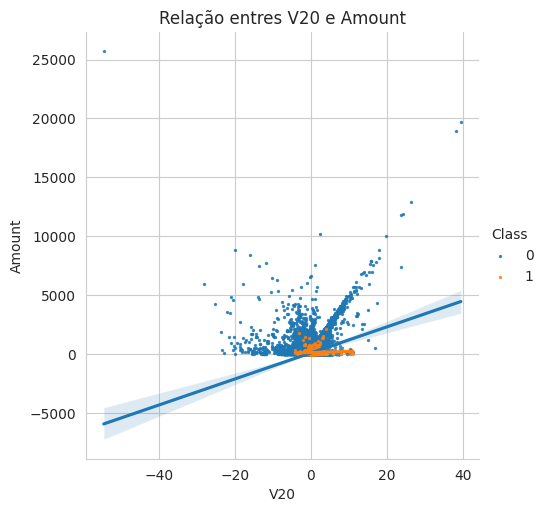

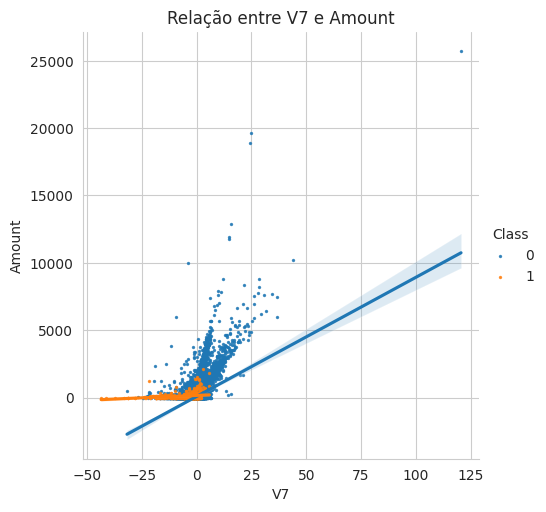

In [48]:
# plotando atributos diretamente correlacionados V20 e V7 com Amount
s = sns.lmplot(x='V20', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2}).set(title="Relação entres V20 e Amount")
s = sns.lmplot(x='V7', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2}).set(title="Relação entre V7 e Amount")
plt.show()

Podemos confirmar que os dois pares de características estão correlacionados (as linhas de regressão para **Class = 0** têm uma inclinação positiva, enquanto a linha de regressão para **Class = 1** tem uma inclinação positiva menor).

Vamos traçar agora os valores correlacionados inversamente.

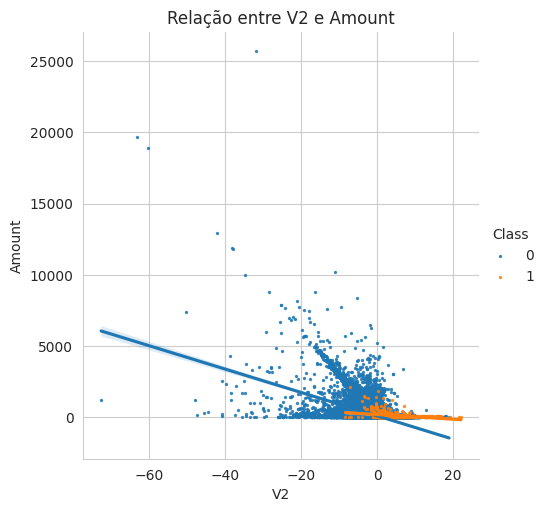

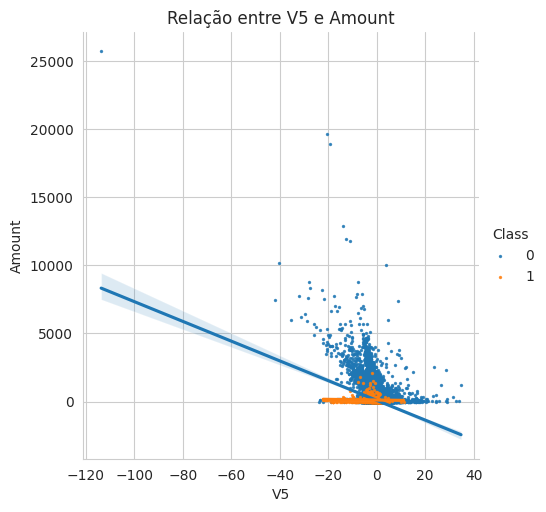

In [50]:
# plotando atributos inversamente correlacionados V2 e V5 com Amount
s = sns.lmplot(x='V2', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2}).set(title="Relação entre V2 e Amount")
s = sns.lmplot(x='V5', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2}).set(title="Relação entre V5 e Amount")
plt.show()

Podemos confirmar que os dois pares de características são inversamente correlacionados (as linhas de regressão para **Class = 0** têm uma inclinação negativa, e as linhas de regressão para **Class = 1** têm uma inclinação pequena negativa).

### 4.4. Gráfico de Densidade de Recursos (*Feature Density*)

O gráfico de densidade possui a mesma função do histograma, mas representa a distribuição como uma curva contínua. A altura da curva no eixo vertical representa uma estimativa da probabilidade de um elemento possuir aquele determinado valor.

<Figure size 640x480 with 0 Axes>

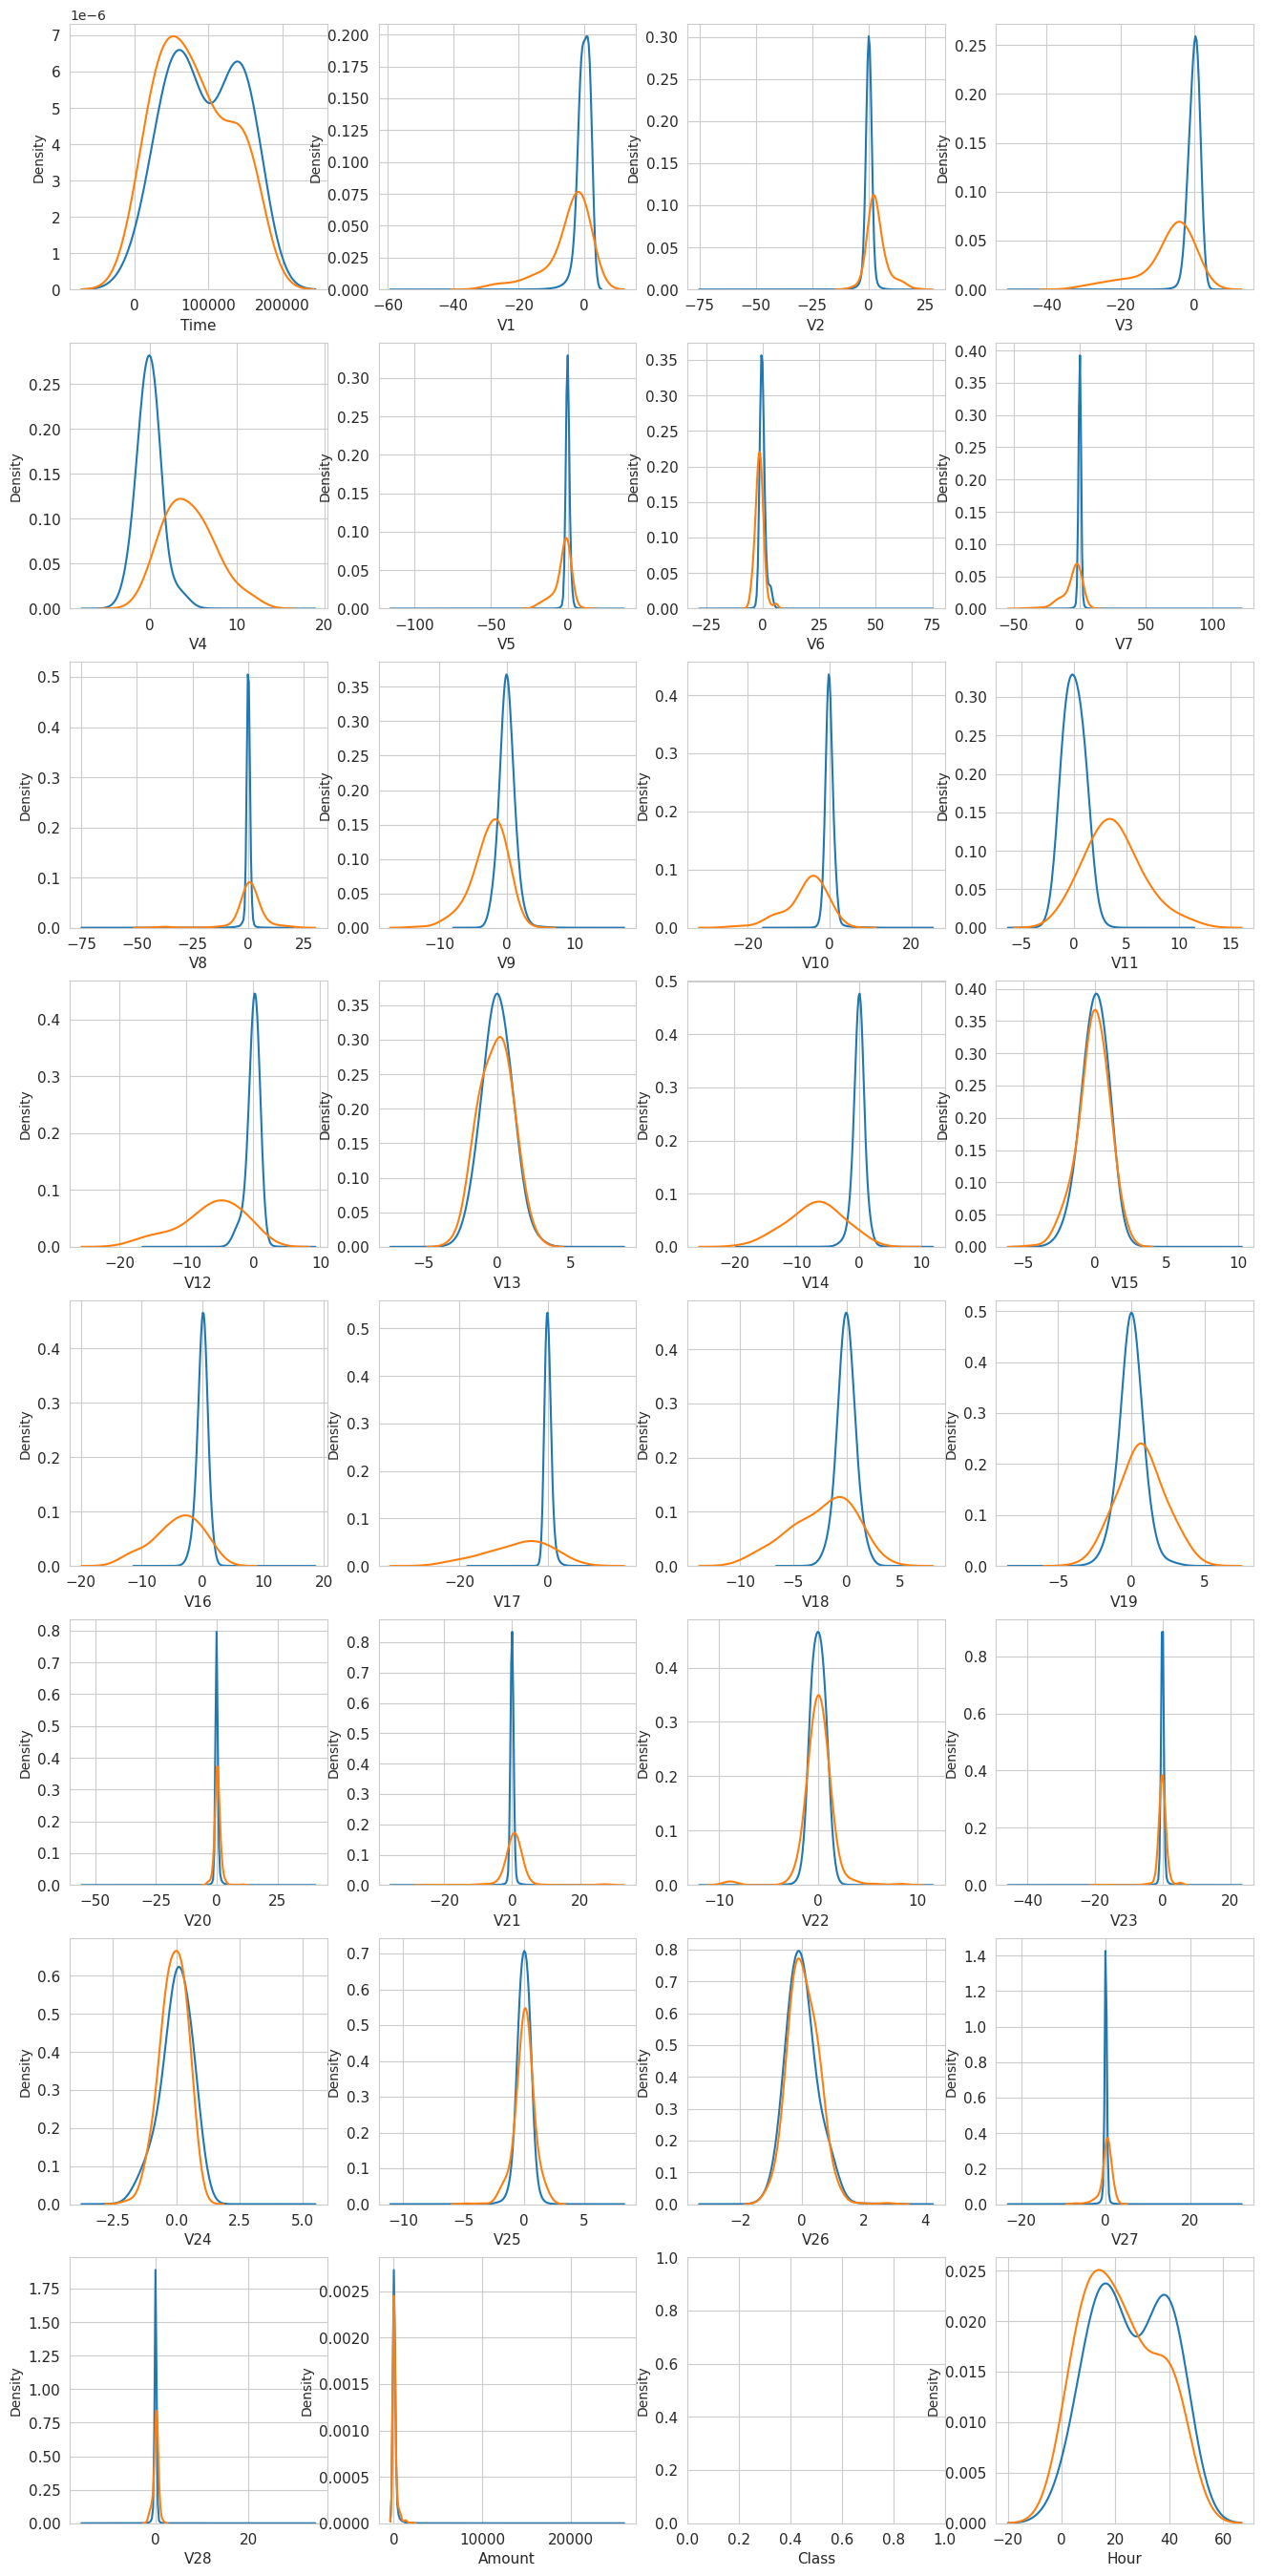

In [29]:
var = dataset.columns.values

i = 0
t0 = dataset.loc[dataset['Class'] == 0]
t1 = dataset.loc[dataset['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,34))

# plota "Feature Density" para todos os atributos
for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=11)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=11)
plt.show();

Para algumas das características podemos observar uma boa seletividade em termos de distribuição. Para **Class**, **V4** e **V11** os valores possuem distribuições claramente separadas, para os valores de **Class** **0 e 1**, **V12**, **V14**, **V18** estão parcialmente separados, **V1**, **V2**, **V3** , **V10** possuem um perfil bastante distinto, enquanto **V25**, **V26**, **V28** possuem perfis semelhantes para os dois valores de **Class**.

Em geral, com poucas exceções (**Time** and **Amount**), a distribuição de características para transações legítimas (valores de **Class = 0**) é centrada em torno de 0, às vezes com uma longa fila em uma das extremidades. Ao mesmo tempo, as transações fraudulentas (valores de **Class = 1**) apresentam uma distribuição assimétrica.

## 5.0 Preparação de Dados
---

Iremos agora definir a lista dos atributos preditores (**Predictors**) e a variável alvo (**Target**). Características categóricas, se houvesem, também poderiam ser definidas nesse ponto do projeto. Mas, no caso do nosso *dataset*, não há necessidade desse recurso.

In [30]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

Nesse ponto, a partir do nosso *dataset* original, vamos definir os subconjuntos de dados de treinamento (**Tran_df**), validação (**Valid_df**) e teste (**Test_df**), com o tamanho dos subconjuntos parametrizados no início do nosso MVP.

In [31]:
# Pega o dataset e divide em train_df e test_df (usando parâmetro TEST_SIZE)
train_df, test_df = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
# Pega o train_df e divide em train_df e valid_df (reduzindo o train_df com o parâmetro VALID_SIZE)
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

<img src="https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/MVP2_Divisao_Dataset.jpg" width="600"/>

In [82]:
# mostrando o percentual do tamanho em cada subconjunto de dados
dataset_size =len(dataset.index)

train_size = (len(train_df.index)/dataset_size)*100
test_size = (len(test_df.index)/dataset_size)*100
valid_size = (len(valid_df.index)/dataset_size)*100

print(f'Nosso Dataset foi dividio em train_df ({train_size:.2f}%), valid_df ({valid_size:.2f}%) e test_df ({test_size:.2f}%)')

Nosso Dataset foi dividio em train_df (64.00%), valid_df (16.00%) e test_df (20.00%)


## 6.0 Modelagem e Treinamento
---
Um modelo preditivo em *Machine Learning*  é - de forma simplificada - uma função matemática que pode ser aplicada a um *Big Data*. O objetivo desse tipo de modelo é evidenciar padrões capazes de apontar tendências e resultados.

Ele se baseia em algoritmos estatísticos e técnicas de ML para calcular probabilidades de resultados, a partir de dados armazenados que ocorreram em um determinado histórico de atividades.

Em um ambiente de negócio cada vez mais competitivo e dinâmico, modelos preditivos vêm crescendo e se tornando cada vez mais populares, ao se mostrarem capazes de previnir riscos e alavancar vendas e lucros.

A técnica de ML que combina múltiplos modelos - em busca de produzir um modelo preditivo mais robusto - é chamada de *ensemble*, que podem possuir métodos sequenciais (dependentes do modelo base) ou paralelos (independentes). Os métodos *ensemble* mais populares são das classes *voting, bagging e boosting*.

Decidimos nesse MVP testar alguns algorítmos dessas classes em nosso *dataset*. A escolha aqui foi pela consideração dos métodos mais populares de cada *ensemble*. Vamos começar pelo método *ensemble* do tipo *bagging*.

### 6.1. Random Forest


*Ensembles* do tipo *bagging* são feitos de vários modelos a partir de diferentes subamostras do conjunto de dados de treinamento.

Um exemplo muito conhecido dos *ensembles* do tipo *bagging* é o algoritmo *Random Forest* (ou Floresta Aleatória), sendo uma evolução do *bagging* tradicional com árvores de decisão. Ele combina as predições de múltiplas árvores de decisão, e em seguida faz-se uma votação para chegar a um único resultado.

Para tal, iremos usar o **RandomForestClassifier**. Inicialmente definiremos os parâmetros do modelo, e em seguida treinaremos o modelo usando o conjunto de dados de treinamento. Depois, então, usaremos o conjunto de validação para realizar a validação.

Utilizaremos como critério de validação **GINI**, cuja fórmula é **GINI = 2 * (AUC) - 1**, onde **AUC** é a **Área Sob Curva (ROC-AUC)**. O número de estimadores é definido como **100** e o número de trabalhos paralelos é definido como **4**.

Começamos inicializando o *RandomForestClassifier*.

In [ ]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Vamos treinar o **RandonForestClassifier** usando os dados **Train_df** e a função **Fit** (demora um pouco...).

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)

Vamos agora prever os valores para os dados **Valid_df**, usando a função **Predict**.

In [ ]:
preds = clf.predict(valid_df[predictors])

Vamos também visualizar a importância dos atributos.


In [ ]:
tmp = pd.DataFrame({'Atributo': predictors, 'Importancia': clf.feature_importances_})
tmp = tmp.sort_values(by='Importancia',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Importância dos Atributos (Random Forest)',fontsize=14)
s = sns.barplot(x='Atributo',y='Importancia',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Descobrimos que as características mais importantes são para os atributos **V17**, **V12**, **V14**, **V16**, **V11** e **V10**.


#### 6.1.1 Matriz de Confusão

Iremos mostrar uma matriz de confusão para os resultados que obtivemos.

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Esperada'], colnames=['Prevista'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Matriz de Confusão (Random Forest)', fontsize=14)
plt.show()

#### 6.1.2 Erro Tipo I e II

Confirmamos acima que a matriz de confusão não é a melhor ferramenta para representar os resultados no nosso caso, em que os dados de fraude e não fraude são desequilibrados.

Na verdade precisaremos de uma métrica diferente que leve em conta ao mesmo tempo tanto a seletividade como a especificidade do método que estamos usando, de modo a minimizar ao mesmo tempo tanto os erros *Tipo I* como os do *Tipo II*.

Lembrando que, quando você rejeita algo que é verdadeiro, você está cometendo um erro do *Tipo I*. E quando não está rejeitando algo falso, você está cometendo um erro do *Tipo II*.

**Hipótese Nula** (**H0**) - A transação não é uma fraude.

**Hipótese Alternativa** (**H1**) - A transação é uma fraude.

**Erro tipo I** - Você rejeita a hipótese nula quando a hipótese nula é realmente verdadeira.

**Erro tipo II** - Você não consegue rejeitar a hipótese nula quando a hipótese alternativa é verdadeira.

**Custo do erro Tipo I** - Você presume erroneamente que a transação é uma fraude e uma transação verdadeira é rejeitada.

**Custo do erro Tipo II** - Você presume erroneamente que a transação não é uma fraude e uma transação fraudulenta é aceita.

A seguir explicamos graficamente o que são erros *Tipo I* e *II*:

<img src="https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/MVP2_Tipo_1_2_a.jpg" width="600"/>


Esta imagem abaixo explica de forma didática as difereças entre *Tipo I e II*:

<img src="https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/MVP2_Tipo_1_2.jpg" width="600"/>

Vamos conhecer agora a área sobre a curva calculando **ROC-AUC**.

In [ ]:
roc_auc_score(valid_df[target].values, preds)

A pontuação **ROC-AUC** obtida com **RandomForrestClassifier** é **0.852**.



### 6.2 Ada Boost

Os *ensembles* do tipo *boosting* são algorítmos sequenciais. Eles criam uma sequência de modelos na qual um modelo tenta corrigir os erros dos modelos anteriores.

*AdaBoost* (*Adaptive Boosting*) foi o primeiro algoritmo de *boosting* bem-sucedido, sendo considerado o mais popular. É um algoritmo meta-heurístico, e pode ser utilizado para aumentar a performance de outros algoritmos de aprendizagem. Para testar esse modelo usaremos o *AdaBoostClassifier*.

Vamos a seguir definir os parâmetros, inicializá-lo e ajustar o modelo com a função "**Fit**".

In [ ]:
# Iniciando o modelo
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

# Ajustando do modelo
clf.fit(train_df[predictors], train_df[target].values)

Vamos agora prever os valores **Target** para os dados **Valid_df**, usando a função "**Predict**".

In [ ]:
preds = clf.predict(valid_df[predictors])

Veremos também a importância dos atributos para *Ada Boost*.

In [ ]:
# plotando o gráfico de importância
tmp = pd.DataFrame({'Atributo': predictors, 'Importancia': clf.feature_importances_})
tmp = tmp.sort_values(by='Importancia',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Importância dos Atributos (Ada Boost)',fontsize=14)
s = sns.barplot(x='Atributo',y='Importancia',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Verificamos que os atributos mais importantes são **V12**, **V14**, **V4**, **V10**, **V18** e **V6**.

Visuaremos a seguir a matriz de confusão do Ada Boost.

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Esperada'], colnames=['Prevista'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Matriz de Confusão (Ada Boost)', fontsize=14)
plt.show()

Vamos conhecer a área sobre a curva calculando **ROC-AUC**.

In [ ]:
roc_auc_score(valid_df[target].values, preds)

A pontuação **ROC-AUC** obtida com *AdaBoostClassifier* é **0,833**.

### 6.3 Cat Boost

Um dos algoritmos de *boosting* para árvores de decisão com suporte para manipulação de dados categóricos é o *CatBoost* (*Category Boosting*). Uma das vantagens desse algoritmo é saber lidar muito bem com variáveis categóricas de um jeito mais intuitivo que outros algoritmos baseados árvores de decisão. Para tal usaremos o *CatBoostClassifier*.

Vamos a seguir definir os parâmetros, inicializá-lo e ajustar o modelo com a função "Fit".

In [ ]:
# Inicializando o modelo
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

# Ajustando o modelo
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

Vamos agora prever os valores **Target** para os dados **Valid_df**, usando a função "**Predict**".

In [ ]:
preds = clf.predict(valid_df[predictors])

Vejamos também os atributos importantes no *Cat Boost*.

In [ ]:
tmp = pd.DataFrame({'Atributo': predictors, 'Importancia': clf.feature_importances_})
tmp = tmp.sort_values(by='Importancia',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Importância dos Atributos (Cat Boost)',fontsize=14)
s = sns.barplot(x='Atributo',y='Importancia',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Verificamos que para o *Cat Boost* os atributos que mais se destacam são **V26**, **V8**, **V4**, **V1**, **V7** e **V22**.

Vamos visualizar a matriz de confusão.

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Esperada'], colnames=['Prevista'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Matriz de Confusão (Cat Boost)', fontsize=14)
plt.show()

Vamos conhecer a área sobre a curva calculando **ROC-AUC**.

In [ ]:
roc_auc_score(valid_df[target].values, preds)

A pontuação ROC-AUC obtida com CatBoostClassifier após 500 iterações foi de **0,857**.

### 6.4 XG Boost

Outro algoritmo de *boosting* é o *XGBoost*, e significa *eXtreme Gradient Boosting*. A principal diferença é que o *XGBoost* usa uma técnica de regularização, usando a métrica do erro diferenciável. Sendo assim, a performance desse algoritmo costuma ser mais flexível e robusta que outros modelos de *boosting*. Para tal usaremos o *XGB*.


Inicializaremos a variável **DMatrix** para treinamento e validação, começando pelos conjuntos de dados. Também definiremos alguns dos parâmetros utilizados para o ajuste do modelo.

In [ ]:
# Preparando do "train_df" e validação do dataset ("valid_df" e "test_df")
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# Definindo O que vamos monitorar (neste caso, "train" e "valid")
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Definindo dos parâmetros XGBoost
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

Aqui treinamos o modelo.

In [ ]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

A melhor pontuação de validação **ROC-AUC** foi **0,983**, para a rodada **262**.

Mostraremos agora a importância dos atributos.

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Importância dos Atributos (XGBoost)", ax=ax, color="blue")
plt.show()

Nesse caso usamos os conjuntos de dados de treinamento e validação. Usaremos o modelo treinado para prever o valor alvo do conjunto de teste.

In [ ]:
preds = model.predict(dtest)

Vamos conhecer a área sobre a curva calculando **ROC-AUC**.

In [ ]:
roc_auc_score(test_df[target].values, preds)


A pontuação **ROC-AUC** para a previsão de dados recentes (conjunto de teste) é **0,979**.

### 6.5 Light GBM

Vamos continuar os testes com outro algoritmo de *boosting*, o *LightGBM*  (*Light Gradient-Boosting Machine*), considerado por muitos o mais veloz e de melhor performance, sendo o principal concorrente do *XGBoost* e do *CatBoost*.

*LightGBM* também lida bem com datasets categóricos e variáveis categóricas, usando o método *binning* ou *bucketing*. Começamos definindo os parâmetros do modelo, e usaremos esses parâmetros apenas para o primeiro modelo.

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # deve ser menor que 2
          'max_depth': 4,  # "-1" significa sem limite
          'min_child_samples': 100,  # número mínimo de dados necessários numa folha
          'max_bin': 100,  # número de compartimentos agrupados para valores
          'subsample': 0.9,  # proporção de amostra da instância de treinamento
          'subsample_freq': 1,  # frequência da subamostra, <=0 significa sem ativação
          'colsample_bytree': 0.7,  # proporção de subamostragem de colunas ao construir cada árvore
          'min_child_weight': 0,  # Soma mínima do peso da instância necessária em uma folha
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split para regularização
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # valor alto porque os dados de treinamento são desequilibrados
         }

Vamos preparar o modelo, criando as estruturas de dados do *dataset* a partir dos conjuntos de treinamento e validação.

In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

Executaremos o modelo usando a função **Train**.

In [ ]:
evals_results = {}


model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  valid_names=['train','valid'],
                  evals_results=evals_results,
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL,
                  feval=None)


A melhor pontuação de validação foi obtida para a rodada **85**, para a qual **ROC-AUC** foi aproximadamente **0,974**.

Vamos representar graficamente a importância da variável.

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Importância dos Atributos (LightGBM)", ax=ax,color="blue")
plt.show()

Vamos prever agora o valor *target* dos dados de teste.

In [ ]:
preds = model.predict(test_df[predictors])

Vamos calcular a pontuação **ROC-AUC** para a previsão.

In [ ]:
roc_auc_score(test_df[target].values, preds)

A pontuação **ROC-AUC** obtida para o conjunto de teste é **0,946**.

Vamos usar agora a **validação cruzada** (*Cross Validation*). Usaremos validação cruzada (***KFolds***). Os dados são divididos em 5 dobras e, por rotação, estamos treinando usando 4 dobras (n-1) e validando usando a 5ª (n-ésima) dobra.

O conjunto de testes é calculado como uma média dessas previsões.

In [ ]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Criando arrays e dataframes para armazenar resultados
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]

    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)

    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1

    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

A pontuação **ROC-AUC** para a previsão dos dados do teste foi de **0,930**. A previsão do teste foi feita a partir da média das previsões.

In [ ]:
pred = test_preds

## 7.0 Avaliação de Resultados
---

Iniciamos esse MVP investigando os dados do *dataset* obtido no site ***Kaglle***, verificando o seu desequilíbrio, visualizando seus recursos e entendendo o relacionamento entre os diferentes atributos.

Em seguida, observamos modelos preditivos. Nosso *dataset* foi dividido em 3 partes: um conjunto de treinamento, um conjunto de validação e um conjunto de teste. Para os primeiros modelos, usamos apenas dados de treinamento e teste.

Começamos com **RandomForrestClassifier**, para o qual obtivemos um código ROC-AUC de **0,852** ao prever o alvo para o conjunto de teste.

Seguimos com o modelo **AdaBoostClassifier**, com pontuação ROC-AUC mais baixa (**0,833**) para previsão dos valores alvo do conjunto de teste.

Depois testamos o **CatBoostClassifier**, com a pontuação ROC-AUC após o treinamento de 500 iterações **0,857**.

Em seguida, experimentamos o modelo **XGBoost**. Neste caso, utilizou-se o conjunto de validação do modelo de treinamento. A melhor pontuação ROC_AUC de validação obtida foi **0,983**. Depois usamos o modelo com a melhor etapa de treinamento para prever o valor alvo a partir dos dados de teste e a pontuação ROC-AUC obtida foi **0,979**.

A seguir apresentamos os nossos dados ao modelo **LightGBM**. Usamos os métodos de **validação dividida** e a **validação cruzada** para avaliar a eficácia do modelo para prever o valor do atributo "*Class*", ou seja, detectar se uma transação era fraudulenta. Com o primeiro método (**validação dividida**)  obtivemos valores de ROC-AUC para validação em torno de **0,974**. Para o conjunto de testes, a pontuação obtida foi **0,946**. Já com a **validação cruzada**, obtivemos uma pontuação de ROC-AUC para a predição do teste de **0,930**.

Depois de analisar todos esses modelos, a pergunta que fica é: *qual o melhor*?

Existem os mais populares, mas não temos como afirmar que um modelo específico será sempre o melhor de todos.

Ao trabalharmos com *Machine Learning* e *Deep Learning* certamente iremos lidar com situações diferentes em ambientes diferentes. E para cada situação específica, um modelo de algorítmo pode apresentar melhores resultados do que o outro, ao lidar melhor com aprendizado supervisionado ou não, atributos com características categóricas ou de cardinalidade, disponibilidade maior ou menor de recursos computacionais, acurácia, *recall*, precisão, escalabilidade, etc.

Ainda há espaço para melhorias, mas a conclusão que tiramos é que os modelos de aprendizado de máquina já desempenham - e cada vez mais desempenharão - um papel crucial na abordagem do problema abordado por esse MVP.

## 8.0 Referências
---

* Portal Terra: https://www.terra.com.br/noticias/perdas-por-fraudes-em-cartoes-de-credito-chegam-a-us-49-bi,d1e8a89c817007ab5d34cee533366a8febpdu8o3.html
* Credit Card Fraud Detection Database: https://www.kaggle.com/mlg-ulb/creditcardfraud  
* RandomForrestClassifier: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
* ROC-AUC: https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
* AdaBoostClassifier: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
* CatBoostClassifier: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/  
* XGBoost API referência em Python: http://xgboost.readthedocs.io/en/latest/python/python_api.html  
* LightGBM implementação em Python: https://github.com/Microsoft/LightGBM/tree/master/python-package  
